In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from Losses import distance_matrix_vector
def get_input_param_optimizer(x, lr):
    input_param = nn.Parameter(x.data)
    optimizer = optim.Adam([input_param], lr=lr)
    return input_param, optimizer
def distance_vectors_pairwise(anchor, positive, negative = None):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    a_sq = torch.sum(anchor * anchor, dim=1)
    p_sq = torch.sum(positive * positive, dim=1)

    eps = 1e-8
    d_a_p = torch.sqrt(a_sq + p_sq - 2*torch.sum(anchor * positive, dim = 1) + eps)
    if negative is not None:
        n_sq = torch.sum(negative * negative, dim=1)
        d_a_n = torch.sqrt(a_sq + n_sq - 2*torch.sum(anchor * negative, dim = 1) + eps)
        d_p_n = torch.sqrt(p_sq + n_sq - 2*torch.sum(positive * negative, dim = 1) + eps)
        return d_a_p, d_a_n, d_p_n
    return d_a_p


In [2]:
from Losses import loss_HardNet
from copy import deepcopy
def loss_HardNegC(anchor, positive, margin = 1.0):
    assert anchor.size() == positive.size(), "Input sizes between positive and negative must be equal."
    assert anchor.dim() == 2, "Inputd must be a 2D matrix."
    eps = 1e-8
    dist_matrix_detach = distance_matrix_vector(anchor, positive.detach()) + eps
    pos1 = distance_vectors_pairwise(anchor,positive)
    eye = torch.autograd.Variable(torch.eye(dist_matrix_detach.size(1))).cuda()
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag = dist_matrix_detach + eye*10
    mask = (dist_without_min_on_diag.ge(0.0008).float()-1)*-1
    mask = mask.type_as(dist_without_min_on_diag)*10
    dist_without_min_on_diag = dist_without_min_on_diag + mask
    min_neg = torch.min(dist_without_min_on_diag,1)[0]
    #loss = 0.5 * torch.mean(loss)
    dist_matrix_detach2 = distance_matrix_vector(anchor.detach(), positive) + eps
    # steps to filter out same patches that occur in distance matrix as negatives
    dist_without_min_on_diag2 = dist_matrix_detach2 + eye*10
    mask2 = (dist_without_min_on_diag2.ge(0.0008).float()-1)*-1
    mask2 = mask2.type_as(dist_without_min_on_diag2)*10
    dist_without_min_on_diag2 = dist_without_min_on_diag2 + mask2
    min_neg2 = torch.min(dist_without_min_on_diag2,0)[0]
    #min_neg_all = torch.min(min_neg.view(-1),min_neg2.view(-1))
    #print min_neg_all.shape
    loss = torch.clamp(margin + pos1 - 0.5*(min_neg2 + min_neg), min=0.0).mean()
    return loss
def detach2(a,p):
    return 0.5* (loss_HardNegC(a,p) + loss_HardNegC(p,a))
def visualize_points(a,p,av,pv,colors,atr = None,ptr = None, start = True):
    import matplotlib.pylab as pylab
    params = {'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    fig = plt.figure()
    if atr is not None:
        for j in range(len(atr)):
            for i in range(len(atr[j])):
                x = [atr[j][i,0], ptr[j][i,0]]
                y = [atr[j][i,1], ptr[j][i,1]]
                if j == 0:
                    plt.plot(x,y, 'o'+colors[i], markerSize = 20,alpha = 0.2)
                    plt.plot(x,y, 'ow', markerSize = 12)
                else:
                    plt.plot(x,y, '.'+colors[i], markerSize = 3)
    for i in range(len(a)):
        x = [a[i,0], p[i,0]]
        y = [a[i,1], p[i,1]]
        xv = np.array([-av[i,0], -pv[i,0]]) * 1.0
        yv = np.array([-av[i,1], -pv[i,1]]) * 1.0
        plt.quiver(x, y, xv, yv, color = colors[i], pivot = 'tail', scale = 2.0,width = 0.01)
        plt.plot(x,y, 'o'+colors[i], markerSize = 20)
        if start:
            plt.plot(x,y, 'ow', markerSize = 12)
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.2,1.2])
    plt.gca().set_aspect('equal', adjustable='box')
    mean_pos_dist = np.sqrt(((a - p)**2).sum(axis = 1) + 1e-12).mean()
    print mean_pos_dist
    import scipy
    dm =  scipy.spatial.distance.cdist(a,p) 
    mean_closes_neg_dist = np.minimum((dm+ 10*np.eye(dm.shape[0])).min(axis = 1), (dm+ 10*np.eye(dm.shape[0])).min(axis = 0))
    print mean_closes_neg_dist.mean()
    plt.text(-1.1,1.0, 'Avg. positive dist.         = '+str(mean_pos_dist)[:4], fontsize=20)
    plt.text(-1.1,0.85, 'Avg. min negative dist. = '+str(mean_closes_neg_dist.mean())[:4], fontsize=20)
    plt.tight_layout()
    #plt.show()
    return fig
def posdist(a1,p1):
    return torch.sqrt(((a1-p1)**2).sum(dim=1) + 1e-12).mean()
def reinitpts(points):
    a = torch.from_numpy(deepcopy(points.astype(np.float32)[:,0,::-1]))
    p = torch.from_numpy(deepcopy(points.astype(np.float32)[:,1,::-1]))
    a1,opt1 = get_input_param_optimizer(a.cuda(),0.01)
    p1,opt2 = get_input_param_optimizer(p.cuda(),0.01)
    return a1,p1,opt1,opt2
#P = torch.from_numpy(points.astype(np.float32))
def optimize_and_show(a1,p1,opt1,opt2, lf, steps = 100, n = 0, title = None):
    atraj = []
    ptraj = []
    for step in range(steps):
        loss = lf(a1,p1) + n*(torch.clamp( torch.abs(a1) - 1, min = 0) + \
                              torch.clamp( torch.abs(p1) - 1, min = 0)).sum()
        if step == steps-1 and loss < 1e-2:
            loss = loss * 0;
        opt1.zero_grad()
        opt2.zero_grad()
        loss.backward() 
        if step==0 :
            fig = visualize_points(a1.cpu().detach().numpy(), p1.cpu().detach().numpy(),
                     a1.grad.cpu().detach().numpy(), p1.grad.cpu().detach().numpy(),
                     colors)
            #plt.title(title +  ', initial')
            fig.savefig(title + str(step)+'.pdf', 
                        bbox_inches = 'tight', pad_inches = 0)
        if step ==steps -1:
            fig = visualize_points(a1.cpu().detach().numpy(), p1.cpu().detach().numpy(),
                     a1.grad.cpu().detach().numpy(), p1.grad.cpu().detach().numpy(),
                     colors, atraj, ptraj, start = False)
            #plt.title(title + ', after ' + str(step) + ' iters')
            fig.savefig(title + str(step)+'.pdf',
                        bbox_inches = 'tight', pad_inches = 0)
        opt1.step()
        opt2.step()
        atraj.append(a1.cpu().detach().numpy())
        ptraj.append(p1.cpu().detach().numpy())
    return
    
    

Points loaded


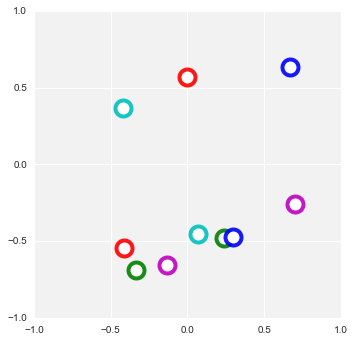

In [3]:

import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = (0.95,0.95,0.95)
plt.rcParams['grid.color'] = 'white'


try:
    points = np.load('points_from_paper.npy')
    print ('Points loaded')
except:
    points = np.random.uniform(-0.7,0.7, (5,2,2))
colors = ['r','g','b','m','c','y', 'k']
for i in range(len(points)):
    x = points[i,:,1]
    y = points[i,:,0]
    plt.plot(x,y, 'o'+colors[i], markerSize = 20, alpha = 0.9)
    plt.plot(x,y, 'ow', markerSize = 12)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


0.968538
0.273172711183
0.235058
0.850884211836
0.968538
0.273172711183
0.0104053
1.02218324132
0.968538
0.273172711183
0.00232543
0.281279552742


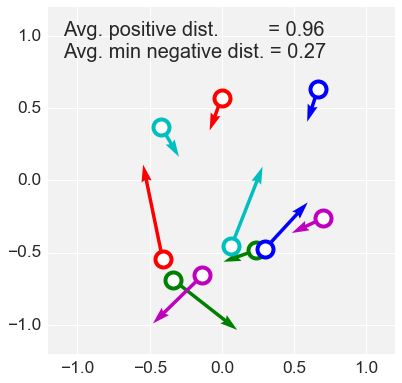

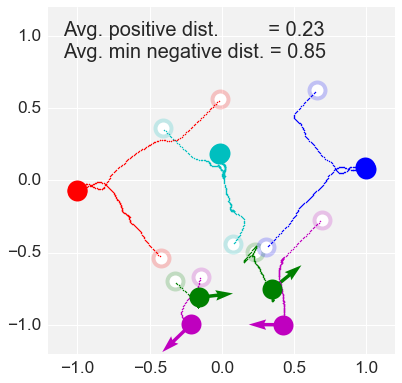

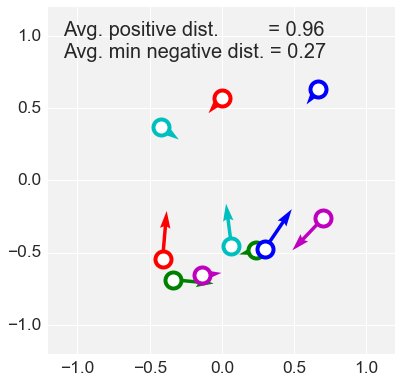

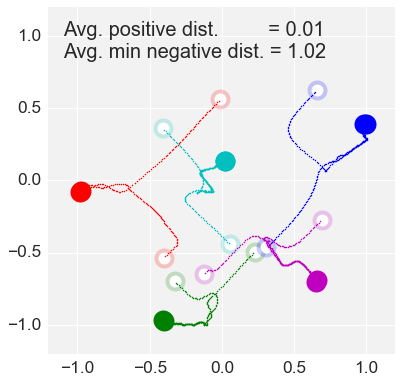

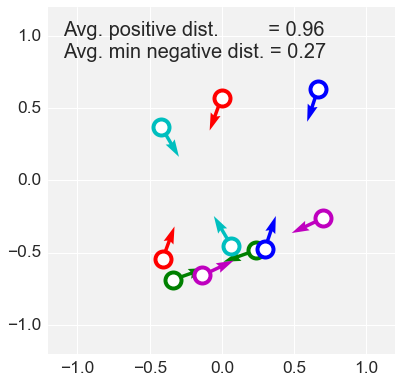

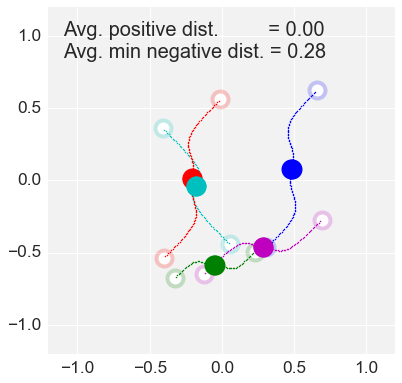

In [5]:

a1,p1,opt1,opt2 = reinitpts(points)
optimize_and_show(a1,p1,opt1,opt2, lf = loss_HardNet, steps = 151, n = 1.0, title = 'HardNetLoss')
#print torch.sqrt(((a1-p1)**2).sum(dim=1)).max(), loss_HardNet(a1,p1, margin = 1)

a1,p1,opt1,opt2 = reinitpts(points)
optimize_and_show(a1,p1,opt1,opt2, lf = detach2, steps = 151, n = 1.0, title = 'HardNegCLoss')
#print torch.sqrt(((a1-p1)**2).sum(dim=1)).max(), loss_HardNet(a1,p1, margin = 1)

a1,p1,opt1,opt2 = reinitpts(points)
optimize_and_show(a1,p1,opt1,opt2, lf = posdist, steps = 151, n = 1.0, title = 'PositiveOnly')
#print torch.sqrt(((a1-p1)**2).sum(dim=1)).max(), loss_HardNet(a1,p1, margin = 1)
                